In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-17-651475734.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


Text(0, 0.5, 'qwerty dimension 2')

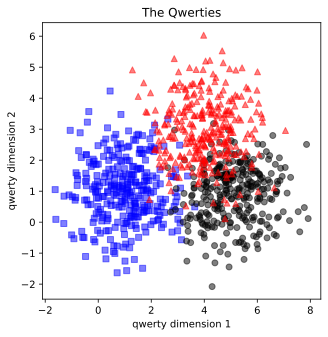

In [18]:
nperclust = 300
blur = 1
A= [1,1]
B= [5,1]
C= [4,3]
a = [A[0]+np.random.randn(nperclust)*blur , A[1]+np.random.randn(nperclust)*blur]
b = [B[0]+np.random.randn(nperclust)*blur , B[1]+np.random.randn(nperclust)*blur]
c = [C[0]+np.random.randn(nperclust)*blur , C[1]+np.random.randn(nperclust)*blur]
labels_np = np.hstack((np.zeros((nperclust)),
                       np.ones((nperclust)),
                       1+np.ones((nperclust))))
data_np= np.hstack((a,b,c)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels ==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels ==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels ==2)[0],1],'r^',alpha=.5)
plt.title('The Qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

In [19]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.1)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
batchsize = 16
train_loader = DataLoader(train_data,batch_size = batchsize , shuffle =True , drop_last = True)
test_loader = DataLoader(test_data,batch_size= test_data.tensors[0].shape[0])

In [25]:
def createTheQwertyNet(optimizerAlgo):
  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.input = nn.Linear(2,8)
      self.fc1 = nn.Linear(8,8)
      self.output = nn.Linear(8,3)
    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      return self.output(x)
  net = qwertyNet()
  lossfun = nn.CrossEntropyLoss()
  optifun = getattr(torch.optim,optimizerAlgo)
  optimizer = optifun(net.parameters(),lr=.01)
  return net,lossfun,optimizer

In [26]:
optim = createTheQwertyNet('RMSprop')[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [30]:
def function2trainTheModel(optimizerType):
  numepochs = 50
  net,lossfun,optimizer = createTheQwertyNet(optimizerType)
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []
  for epochi in range(numepochs):
    net.train()
    batchAcc = []
    batchLoss = []
    for X,y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())
      matches = torch.argmax(yHat,axis=1)==y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append(accuracyPct)
    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)
    net.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis =1)==y).float()))
  return trainAcc,testAcc,losses,net

In [31]:
def plotTheResults(optimizerType):
  yHat = net(data)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()
  totalAcc = torch.mean(100*accuracy).item()
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])
  fig,ax = plt.subplots(2,2,figsize=(10,6))
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Losses')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title(f'{optimizerType}: Losses')

  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title(f'{optimizerType}:Accuracy')
  ax[0,1].legend()

  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy%')
  ax[1,0].set_title(f'{optimizerType}: Accuracy By Group')

  colorShapes = ['bs','ko','g^']
  for i in range(3):
    ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
    idxErr = (accuracy==0) & (labels ==i)
    ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')
  ax[1,1].set_title(f'{optimizerType}: Total accuracy :{totalAcc:.2f}')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()

  plt.tight_layout()

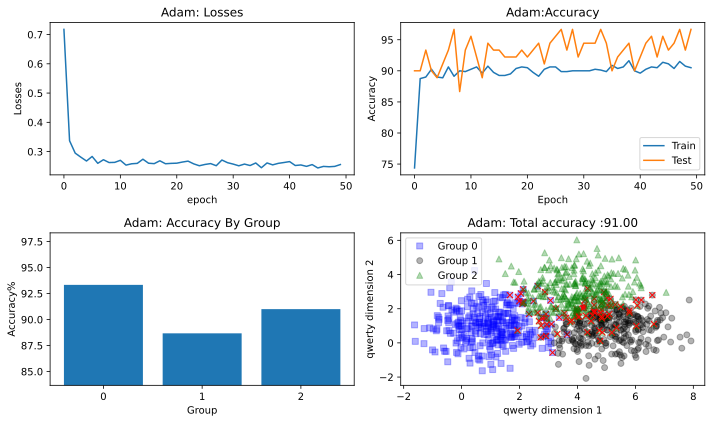

In [32]:
optimizerType = 'Adam'
trainAcc,testAcc,losses,net = function2trainTheModel(optimizerType)
plotTheResults(optimizerType)

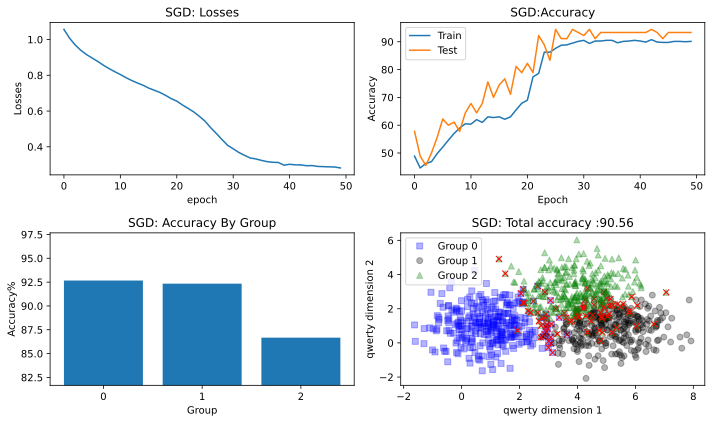

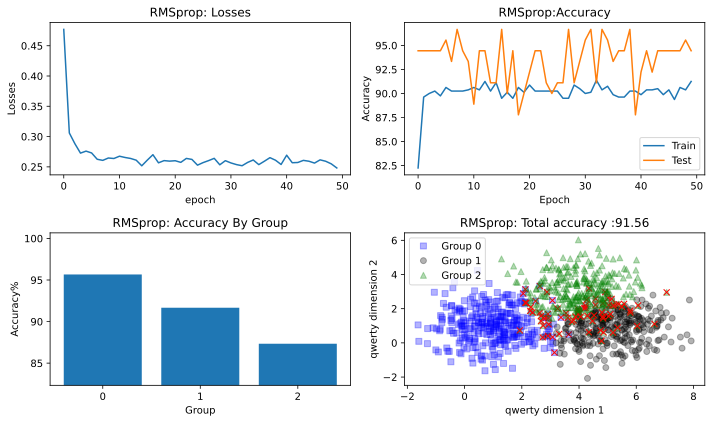

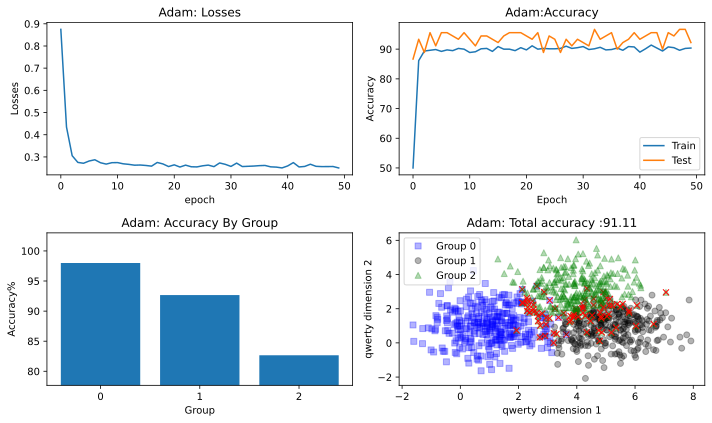

In [33]:
performance = []
for opto in ['SGD','RMSprop','Adam']:
  trainAcc,testAcc,losses,net = function2trainTheModel(opto)
  plotTheResults(opto)
  train = np.mean(trainAcc[-10:])
  test = np.mean(testAcc[-10:])
  performance.append(f'{opto}: train {train:.1f}%, test {test:.1f}%')

In [34]:
performance

['SGD: train 90.1%, test 93.2%',
 'RMSprop: train 90.3%, test 94.1%',
 'Adam: train 90.2%, test 94.4%']